# Colormap Normalization
[Colormap Normalizations — Matplotlib 3.4.2 documentation](https://matplotlib.org/stable/gallery/userdemo/colormap_normalizations.html#sphx-glr-gallery-userdemo-colormap-normalizations-py)

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation
from IPython.display import HTML

In [2]:
# Collect .athdf outputs
athinput = athena_read.athinput('athinput.si')
outputs = sorted(list(Path('athdf').glob(athinput["job"]["problem_id"]+'.out2.*.athdf')))

In [3]:
# Init sim constants and grid
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s / Omega                            # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf(outputs[0])
xf, zf = data['x1f'] / H, data['x2f'] / H

In [4]:
# Load data into memory
times = []
rhops = []

for output in outputs:
    data = athena_read.athdf(output)
    times.append(data['Time'] / T)
    rhops.append(data['rhop'][0]) # [0] effectively flattens 3D array

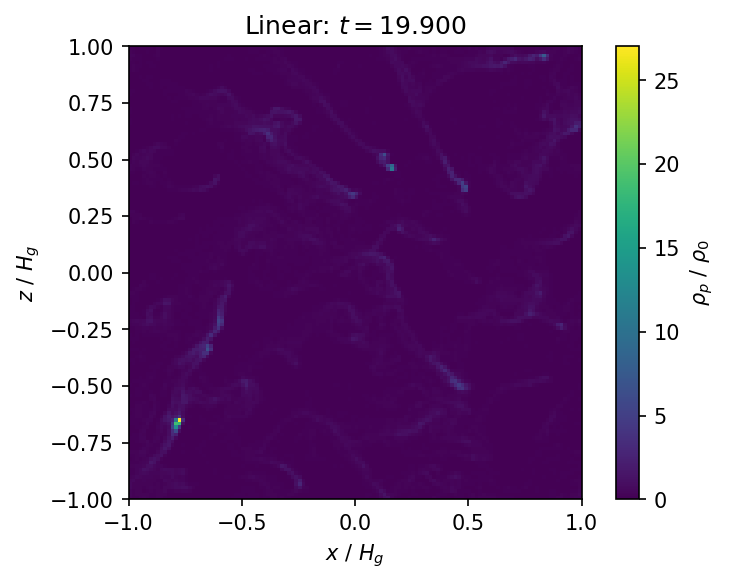

In [5]:
# Initialize frame
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.set_title('Linear: $t={:.3f}$'.format(times[0]))
ax.set_xlabel('$x$ / $H_g$')
ax.set_ylabel('$z$ / $H_g$')
img = ax.pcolormesh(xf, zf, rhops[0])
cb = plt.colorbar(img)
cb.set_label(r'$\rho_p$ / $\rho_0$')

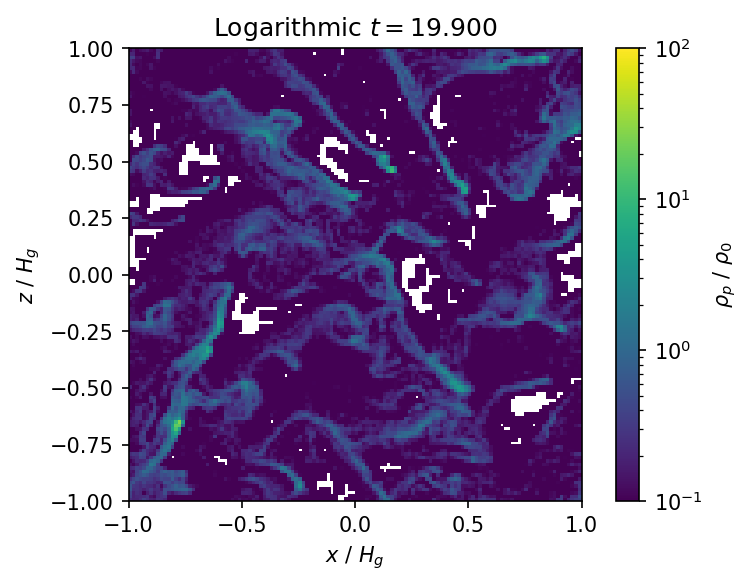

In [6]:
# Initialize frame
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.set_title('Logarithmic $t={:.3f}$'.format(times[0]))
ax.set_xlabel('$x$ / $H_g$')
ax.set_ylabel('$z$ / $H_g$')
img = ax.pcolormesh(xf, zf, rhops[0], norm=colors.LogNorm(vmin=0.1, vmax=100))
cb = plt.colorbar(img)
cb.set_label(r'$\rho_p$ / $\rho_0$')